# Импорт

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import PIL.Image as Image

import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

from LookGenerator.datasets.utils import load_image
from LookGenerator.datasets.person_segmentation_dataset import PersonSegmentationDataset, PersonSegmentationDatasetMultichannel
from LookGenerator.networks.segmentation import UNet
from LookGenerator.networks.trainer import Trainer
from LookGenerator.networks.losses import FocalLossMulti
from LookGenerator.networks.utils import load_model
import LookGenerator.datasets.transforms as custom_transforms
from LookGenerator.networks_training.utils import check_path_and_creat

# Загрузка данных

In [2]:
transform_input = transforms.Compose([
    transforms.Resize((256, 192)),
    transforms.RandomAffine(scale=(0.8, 1), degrees=(-90,90), fill = 0.9),
    transforms.ColorJitter(brightness=(0.5, 1), contrast=(0.4,1),  hue=(0, 0.3)),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.25, 0.25, 0.25]
    )
])

transform_output = transforms.Compose([
    transforms.Resize((256, 192)),
    transforms.RandomAffine(scale=(0.8, 1), degrees=(-90,90), fill = 0),
    custom_transforms.MinMaxScale(),
    custom_transforms.ThresholdTransform(threshold=0.5)
])

In [3]:
batch_size_train = 32
batch_size_val = 16
pin_memory = True
num_workers = 12

In [4]:
train_dataset = PersonSegmentationDatasetMultichannel(r'C:\Users\DenisovDmitrii\Desktop\trainData',
    #r"C:\Users\DenisovDmitrii\Desktop\trainData",
                                                      transform_input=transform_input,
                                                      transform_output=transform_output)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True, pin_memory=pin_memory, num_workers=num_workers)
(len(train_dataset), len(train_dataloader))

(11647, 364)

In [5]:
val_dataset = PersonSegmentationDatasetMultichannel(r'C:\Users\DenisovDmitrii\Desktop\valData',
    #r"C:\Users\DenisovDmitrii\Desktop\trainData",
                                                      transform_input=transform_input,
                                                      transform_output=transform_output
                                                    )#r"C:\Users\DenisovDmitrii\Desktop\valData")
val_dataloader = DataLoader(val_dataset, batch_size=batch_size_val, shuffle=False, pin_memory=pin_memory, num_workers=num_workers)
(len(val_dataset), len(val_dataloader))

(2032, 127)

Test load train_dataloader. and val.

In [ ]:
for X, y in train_dataloader:
    print(X.shape)
    print(y.shape)
    print(X.requires_grad)
    X = transforms.ToPILImage() (X[0])
    X = np.array(X)
    plt.imshow(X)
    plt.show()
    y = transforms.ToPILImage()(y[0,11])
    y = np.array(y)
    plt.imshow(y, cmap='binary')
    plt.show()

    break

# Обучение модели

In [ ]:
for X, y in val_dataloader:
    print(X.shape)
    print(y.shape)
    print(X.requires_grad)
    X = transforms.ToPILImage() (X[0])
    X = np.array(X)
    plt.imshow(X)
    plt.show()
    y = transforms.ToPILImage()(y[0,11])
    y = np.array(y)
    plt.imshow(y, cmap='binary')
    plt.show()

    break

Метки классов на изображении:

1. Левое лицо                       248,251,14
2. Правое лицо                      251,235,25
3. Туловище                         20,80,194
4. Внешняя верхняя левая рука       190,189,96
5. Внешняя верхняя правая рука      215,187,88
6. Внешняя нижняя левая рука        252,206,48
7. Внешняя нижняя правая рука       250,220,36
8. Внутренняя верхняя левая рука    145,191,116
9. Внутренняя верхняя правая рука   170,190,105
10. Внетренняя нижняя левая рука     228,191,74
11. Внутренняя нижняя правая рука    240,198,60
12. Левая кисть                      8,110,221
13. Правая кисть                     4,98,224
14. Левая нога                       22,173,184
15. Правая нога                      6,166,198

In [8]:
model = UNet(in_channels=3, out_channels = 15, features=(64, 128, 256, 512, 1024))
#model = load_model(model, r'C:\Users\DenisovDmitrii\Desktop\segmentation_weits\session12\asd.pt')
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
criterion = FocalLossMulti(device=device)
print(device)

cuda


In [9]:
save_directory = r'C:\Users\DenisovDmitrii\OneDrive - ITMO UNIVERSITY\peopleDetector\segmentationMulty\weights\testMulty_64_128_256_512_1024'
check_path_and_creat(save_directory)

True

In [10]:
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.benchmark = True

In [11]:
trainer = Trainer(
    model_=model, optimizer=optimizer, criterion=criterion,
    device=device, save_directory=save_directory, save_step=1, verbose=True
)

In [12]:
epoch_num=30

In [ ]:
trainer.train(train_dataloader=train_dataloader, val_dataloader=val_dataloader, epoch_num=epoch_num)

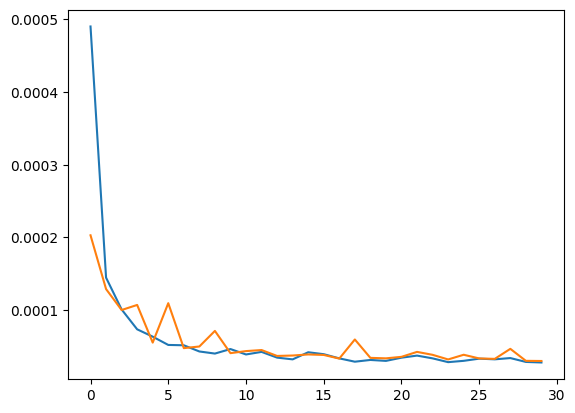

In [14]:
trainer.draw_history_plots()

In [15]:
from torchsummary import summary
summary(model.to('cuda'), (3, 256, 192))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 192]           1,792
       BatchNorm2d-2         [-1, 64, 256, 192]             128
         LeakyReLU-3         [-1, 64, 256, 192]               0
         LeakyReLU-4         [-1, 64, 256, 192]               0
           Conv3x3-5         [-1, 64, 256, 192]               0
            Conv2d-6         [-1, 64, 256, 192]          36,928
       BatchNorm2d-7         [-1, 64, 256, 192]             128
           Conv3x3-8         [-1, 64, 256, 192]               0
         LeakyReLU-9         [-1, 64, 256, 192]               0
        LeakyReLU-10         [-1, 64, 256, 192]               0
          Conv5x5-11         [-1, 64, 256, 192]               0
        MaxPool2d-12          [-1, 64, 128, 96]               0
           Conv2d-13         [-1, 128, 128, 96]          73,856
      BatchNorm2d-14         [-1, 128, 

In [ ]:
model = load_model(model, r'C:\Users\Даша\PycharmProjects\SMBackEnd\LookGenerator\weights\unet_epoch_0_0.0161572862694324.pt')
model.eval()

In [ ]:
test_dir = r""
test_folder = ""
save_masks_dir = r""
list_files = os.listdir(test_dir)
images = [file.split('.') for file in list_files]

In [ ]:
for image in images:
    print(image)
    img = load_image(test_dir, test_folder, image, '.jpg')
    img_to_model = prepare_image_for_model(img, transform_input)
    modelled = model(img_to_model)
    mask = to_array_from_model_bin(modelled)

    plt.figure(figsize=(18, 6))
    plt.subplot(1,2,0)
    plt.imshow(img)
    plt.subplot(1,2,1)
    plt.imshow(mask)

    Image.fromarray(mask, 'L').save(save_masks_dir + image + '.png')
